# Medical Term Retrieval Analysis

This notebook breaks down the search terms retrieval analysis into logical components that can be run independently.

In [1]:
from collections import OrderedDict
import typing as typ

import pydantic

from dataloader.base import DatasetConfig

import hashlib
from pathlib import Path
import config as cnf
import utils as exp_utils

from dataloader import load_dataset, DATASET_CONFIGS

from retrieval.qdrant_search import client as qdrant_client
from retrieval.qdrant_search import models as qdrant_models
from retrieval.qdrant_search import factory as qdrant_factory

## Configuration

Define the configuration parameters for the experiment

In [3]:
class Arguments(pydantic.BaseModel):
    provider: str = "vllm"  # "azure" | "vllm" | "mistral"
    base_model: dict[str, typ.Any] = {
        "provider": "vllm",
        "deployment": "deepseek-ai/DeepSeek-R1-Distill-Llama-70B",
        "api_base": "http://localhost:6539/v1",
        "endpoint": "completions",
        "use_cache": True,
    }

    analyse_agent: dict[str, typ.Any] = {
        "agent_type": "base",
        "prompt_name": "analyse_agent/base_v1",
    }
    temperature: float = 0.0
    max_tokens: int = 10_000
    seed: int = 1  # e.g., "1:2:3:4:5"
    batch_size: int = 2
    num_workers: int = 4
    embed_config: list[dict[str, str]] = [
        {
            "type": "st",
            "model_name": "pritamdeka/S-PubMedBert-MS-MARCO",
            "query_key": "output",
        }
    ]

    qdrant_config: qdrant_models.FactoryConfig = qdrant_models.FactoryConfig()
    distance: str = "Cosine"
    hnsw: dict[str, int] = {"m": 32, "ef_construct": 256}

    rank: int = 25

    experiment_id: str = "search-terms-per-query"
    experiment_name: str = "S-PubMedBert-MS-MARCO"

    debug: bool = False

    def get_hash(self) -> str:
        """Create unique identifier for the arguments"""
        model_dict = self.model_dump(exclude={"experiment_id", "experiment_name"})
        return hashlib.md5(str(model_dict).encode()).hexdigest()

    def get_experiment_folder(self) -> Path:
        """Get the experiment folder path."""
        return (
            cnf.DUMP_FOLDER
            / f"{self.experiment_id}/{self.experiment_name}/{self.get_hash()}"
        )

# Initialize arguments
args = Arguments()

## Data Loading and Preprocessing

Load and prepare the MDACE dataset and ICD trie

In [4]:
# Create experiment folder
args.get_experiment_folder().mkdir(parents=True, exist_ok=True)

# Save configuration
with open(args.get_experiment_folder() / "config.json", "w") as f:
    f.write(args.model_dump_json(indent=2))

# Initialize Qdrant service
qdrant_service = qdrant_client.QdrantSearchService(
    **args.qdrant_config.model_dump()
)

# Build ICD trie and get codes
xml_trie = exp_utils.build_icd_trie(year=2022)
icd10cm = [code.name for code in xml_trie.get_root_codes("cm")]
eval_trie: dict[str, int] = OrderedDict(
    {code: idx for idx, code in enumerate(sorted(icd10cm), start=1)}
)

Downloaded ICD version 2022 successfully!

 Following files will be parsed: ['2022-official-icd-10-pcs-coding-guidelines-updated-december-1-2021.pdf', 
'fy-2022-icd-10-cm-coding-guidelines-updated-02012022.pdf', 'icd10pcs_tables_2022.xml', 'icd10pcs_index_2022.xml', 
'icd10cm_tabular_2022.xml', 'icd10cm_neoplasm_2022.xml', 'icd10cm_index_2022.xml', 'icd10cm_eindex_2022.xml', 
'icd10cm_drug_2022.xml'] 

Output()

Output()

Output()

Output()

In [5]:
# Load and format MDACE dataset
mdace = load_dataset(DatasetConfig(**DATASET_CONFIGS["mdace-icd10cm"]))
mdace = exp_utils.format_dataset(mdace, xml_trie, debug=args.debug)

# Add evidence field
mdace = mdace.map(
    lambda x: {
        **x,
        "evidence": [
            " ".join(
                x["note"][loc[0] : loc[-1] + 1] for loc in annotation["locations"]
            )
            for annotation in x["evidence_spans"]
        ],
    }
)

## Term Retrieval with and without cross-references

Process assignable terms and perform retrieval

In [39]:
queries = mdace.to_list()
embed_config: list[dict[str, str]] = [
        {
            "type": "st",
            "model_name": "pritamdeka/S-PubMedBert-MS-MARCO",
            "query_key": "evidence",
        }
    ]
# Process assignable terms
terms = [
    term.model_dump() for term in xml_trie.index.values()
]
terms.sort(key=lambda x: x["id"])
print(f"Fetched {len(terms)} assignable terms.")

# Create and ensure index
index_finger_print = qdrant_factory.ensure_qdrant_index(
    data=terms,
    text_key="path",
    model_cfg=embed_config,
    hnsw_cfg=args.hnsw,
    distance=args.distance,
    service=qdrant_service,
    payload_keys=["id", "code"],
)

# Perform search
base_evidence_results = qdrant_factory.search(
    data=mdace.to_list(),
    model_cfg=embed_config,
    service=qdrant_service,
    index_name=index_finger_print,
    limit=25,
)

base_retrieved_codes = []
cross_reference_terms = []
for idx, res in enumerate(base_evidence_results):
    accumulated_codes = set()
    terms = []
    for point in res.points:
        if not point.payload:
            continue
        term = xml_trie.index[point.payload["id"]]
        if term.see:
            terms.append(term.see)
        if term.see_also:
            terms.append(term.see_also)
        accumulated_codes.update(
            xml_trie.get_term_codes(term.id, subterms=False)
        )
    queries[idx]["evidence"].extend(terms)
    base_retrieved_codes.append(list(accumulated_codes))

Fetched 148660 assignable terms.


Output()

In [40]:
embed_config: list[dict[str, str]] = [
        {
            "type": "st",
            "model_name": "pritamdeka/S-PubMedBert-MS-MARCO",
            "query_key": "evidence",
        }
    ]

# Perform search
extended_evidence_results = qdrant_factory.search(
    data=queries,
    model_cfg=embed_config,
    service=qdrant_service,
    index_name=index_finger_print,
    limit=25,
)

extended_retrieved_codes = []
for idx, res in enumerate(extended_evidence_results):
    accumulated_codes = set()
    for point in res.points:
        if not point.payload:
            continue
        term = xml_trie.index[point.payload["id"]]
        accumulated_codes.update(
            xml_trie.get_term_codes(term.id, subterms=False)
        )
    extended_retrieved_codes.append(list(accumulated_codes))

Output()

## Evaluation

Plot recall for each chapter

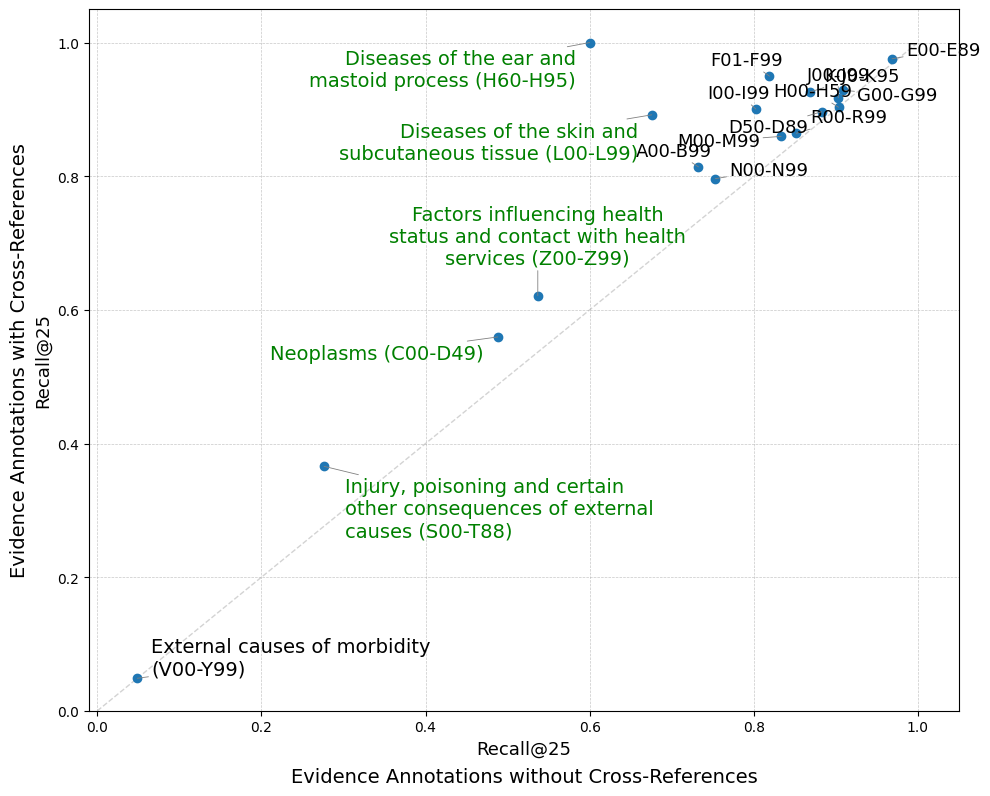

In [41]:
import matplotlib.pyplot as plt
import pandas as pd
import textwrap                       # NEW
from collections import Counter, defaultdict

all_target_codes = [code for row in mdace["targets"] for code in row]
codes_by_chapter = [xml_trie.get_chapter_id(code) for code in all_target_codes]
chapters = {
    xml_trie.get_chapter_id(code): xml_trie.get_chapter(code) for code in all_target_codes
}
chapter_freq = Counter(codes_by_chapter)

chapter_data = defaultdict(dict)
for chapter_id, freq in chapter_freq.items():
    chapter_data[chapter_id] = {
        "label": f"{chapters[chapter_id].min}-{chapters[chapter_id].max}",
    }

# --- per-chapter recall ---
base_chapters_tp = Counter()
base_chapters_total = Counter()

for idx, res in enumerate(base_retrieved_codes):
    row = mdace[idx]
    target_codes = row["targets"]

    for code in target_codes:
        ch_id = xml_trie.get_chapter_id(code)
        base_chapters_total[ch_id] += 1
        if code in res:
            base_chapters_tp[ch_id] += 1

extended_chapters_tp = Counter()
extended_chapters_total = Counter()

for idx, res in enumerate(extended_retrieved_codes):
    row = mdace[idx]
    target_codes = row["targets"]

    for code in target_codes:
        ch_id = xml_trie.get_chapter_id(code)
        extended_chapters_total[ch_id] += 1
        if code in res:
            extended_chapters_tp[ch_id] += 1

# --- dataframe for plotting ---
total_targets = len(all_target_codes)
rows = []
for ch_id, freq in chapter_freq.items():
    base_recall = base_chapters_tp[ch_id] / base_chapters_total[ch_id] if base_chapters_total[ch_id] else 0.0
    extended_recall = extended_chapters_tp[ch_id] / extended_chapters_total[ch_id] if extended_chapters_total[ch_id] else 0.0
    rows.append(
        {
            "chapter_id": ch_id,
            "frequency": freq,
            "extended_recall": extended_recall,
            "base_recall": base_recall,
            "label": chapter_data[ch_id]["label"],
        }
    )

df = pd.DataFrame(rows)
df = df[df["frequency"] >= 5]

# -----------------------------------------------------------------------------   
# Scatter plot with call-out labels
plt.figure(figsize=(10, 8))
plt.scatter(df["base_recall"], df["extended_recall"], zorder=2)
plt.xlabel("Recall@25", fontsize=13)
plt.ylabel("Recall@25", fontsize=13)
# Diagonal reference line (y = x) in light grey
plt.plot([0, 1], [0, 1], linestyle='--', color='lightgrey', linewidth=1, zorder=1)


plt.text(
    0.5, -0.08, "Evidence Annotations without Cross-References",
    transform=plt.gca().transAxes,
    ha="center", va="top", fontsize=14
)

# Add subtitle beside y-axis
plt.text(
    -0.08, 0.5, "Evidence Annotations with Cross-References",
    transform=plt.gca().transAxes,
    ha="center", va="center", rotation="vertical", fontsize=14
)

# Pre-compute medians to decide which way to push each label
x_med = df["base_recall"].median()
y_med = df["extended_recall"].median()

manual_offsets = {
    "L00-L99": {"dx": -10, "dy": -5, "ha": "right", "va": "top"},
    "I00-I99":   {"dx": 10, "dy": 5,    "ha": "right",  "va": "bottom"},
    "Z00-Z99": {"dx": 0, "dy": 20, "ha": "center", "va": "bottom"},
    "J00-J99": {"dx": 0, "dy": 10, "ha": "center", "va": "bottom"},
    "E00-E89": {"dx":  10, "dy": 0,  "ha": "left",  "va": "bottom"},
    "Q00-Q99":   {"dx": 12, "dy": 7, "ha": "left", "va": "bottom"},  # vertically above
    "C00-D49":   {"dx": -10, "dy": -5, "ha": "right", "va": "top"},
    "S00-T88":   {"dx": 15, "dy": -8, "ha": "left", "va": "top"},     # directly below
    "M00-M99":   {"dx": -15, "dy": -10,  "ha": "right", "va": "bottom"},
    "H60-H95": {"dx": -10, "dy": -5, "ha": "right", "va": "top"},
    "H00-H59": {"dx": 10, "dy": 5,    "ha": "right",  "va": "bottom"},
    "G00-G99": {"dx": 10, "dy": -10,  "ha": "left", "va": "bottom"},
    "F01-F99": {"dx": 10, "dy": 5,    "ha": "right",  "va": "bottom"},
    "A00-B99": {"dx": 10, "dy": 5,    "ha": "right",  "va": "bottom"},
    "D50-D89": {"dx": -10, "dy": -5, "ha": "right", "va": "top"},
    "N00-N99":   {"dx":  10, "dy": 0,  "ha": "left",  "va": "bottom"},
    "V00-Y99":   {"dx":  10, "dy": 0,  "ha": "left",  "va": "bottom"},
    "default":   {"dx": 10, "dy": 5,    "ha": "left",  "va": "bottom"},
}


red_highlight_labels = []
green_highlight_labels = ["H60-H99", "L00-L99", "Z00-Z99", "H60-H95", "C00-D49", "S00-T88"]
highlight_labels = red_highlight_labels + green_highlight_labels
for _, r in df.iterrows():
    x, y, label, ch_id = r["base_recall"], r["extended_recall"], r["label"], r["chapter_id"]
    color = "red" if label in red_highlight_labels else ("green" if label in green_highlight_labels else "black")
    font_size = 13
    # Pick a direction: push left or right, up or down away from the plot centre

    opts = manual_offsets.get(r["label"], manual_offsets["default"])
    dx, dy = opts["dx"], opts["dy"]
    ha, va = opts["ha"], opts["va"]

    if label in highlight_labels or label in["V00-Y99", "C00-D49", "S00-T88"]:
        label = chapters[ch_id].description
        font_size = 14
    wrapped = textwrap.fill(label, width=30)

    # Annotate with an arrow-less leader line (arrowstyle "-" draws a straight line)
    plt.annotate(
        wrapped,
        xy=(x, y),
        xytext=(dx, dy),
        textcoords="offset points",
        ha=ha,
        va=va,
        fontsize=font_size,
        color=color,
        arrowprops=dict(
            arrowstyle="-",
            shrinkA=0,
            shrinkB=0,
            lw=0.6,
            color="grey",
        ),
        zorder=3
    )
plt.ylim(0.0, 1.05)
plt.xlim(-0.01, 1.05)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [42]:
df.rename(columns={
    "base_recall": "base",
    "extended_recall": "with_cross_references"
}, inplace=True)

# Compute recall difference
df["recall_change"] = df["with_cross_references"] - df["base"]

# Compute overall weighted values
total_freq = df["frequency"].sum()
overall_base = (df["frequency"] * df["base"]).sum() / total_freq
overall_cross = (df["frequency"] * df["with_cross_references"]).sum() / total_freq
overall_change = overall_cross - overall_base

# Create summary row
summary_row = pd.DataFrame([{
    "chapter_id": "overall",
    "frequency": total_freq,
    "base": overall_base,
    "with_cross_references": overall_cross,
    "recall_change": overall_change,
    "label": "All Chapters"
}])


df_with_summary = pd.concat([df, summary_row], ignore_index=True)
df_with_summary = df_with_summary[["chapter_id", "frequency", "base", "with_cross_references", "recall_change", "label"]]

df_with_summary.sort_values(by="chapter_id")

,chapter_id,frequency,base,with_cross_references,recall_change,label
5,cm_1,86,0.732558,0.813953,0.081395,A00-B99
8,cm_10,206,0.902913,0.917476,0.014563,J00-J99
4,cm_11,244,0.868852,0.926230,0.057377,K00-K95
16,cm_12,37,0.675676,0.891892,0.216216,L00-L99
7,cm_13,114,0.833333,0.859649,0.026316,M00-M99
10,cm_14,162,0.753086,0.796296,0.043210,N00-N99
9,cm_18,162,0.851852,0.864198,0.012346,R00-R99
12,cm_19,123,0.276423,0.365854,0.089431,S00-T88
14,cm_2,84,0.488095,0.559524,0.071429,C00-D49
13,cm_20,41,0.048780,0.048780,0.000000,V00-Y99


## Group by code

In [88]:
from trie.models import Term


def make_group_id(term: Term, cross_references: bool = False) -> str:
    if not term.code:
        return term.id if cross_references else ""
    key_tuple = (
        term.code,
        term.manifestation_code if term.manifestation_code else "",
        hashlib.md5(term.see.encode()).hexdigest() if term.see else "",
        hashlib.md5(term.see_also.encode()).hexdigest() if term.see_also else "",
    )
    key_str = "-".join(key_tuple)
    return key_str

In [100]:
queries = mdace.to_list()
embed_config: list[dict[str, str]] = [
        {
            "type": "st",
            "model_name": "pritamdeka/S-PubMedBert-MS-MARCO",
            "query_key": "evidence",
        }
    ]
# Process assignable terms
all_terms = [
    {
        **term.model_dump(), 
        "group": make_group_id(term, cross_references=True),
    } for term in xml_trie.index.values()
]

# Create and ensure index
index_finger_print = qdrant_factory.ensure_qdrant_index(
    data=all_terms,
    text_key="path",
    model_cfg=embed_config,
    hnsw_cfg=args.hnsw,
    distance=args.distance,
    service=qdrant_service,
    payload_keys=["id", "group"],
    recreate=True,
)

# Perform search
groped_evidence_results = qdrant_factory.search_by_group(
    data=mdace.to_list(),
    group_key="group",
    model_cfg=embed_config,
    service=qdrant_service,
    index_name=index_finger_print,
    limit=50,
    group_size=1,
)

grouped_retrieved_codes = []
cross_reference_terms = []
for idx, res in enumerate(groped_evidence_results):
    accumulated_codes = set()
    terms = []
    for point in res.points:
        if not point.payload:
            continue
        term = xml_trie.index[point.payload["id"]]
        if term.see:
            terms.append(term.see)
        if term.see_also:
            terms.append(term.see_also)
        accumulated_codes.update(
            xml_trie.get_term_codes(term.id, subterms=False)
        )
    queries[idx]["evidence"].extend(terms)
    grouped_retrieved_codes.append(list(accumulated_codes))

2025-05-28 16:11:57.868 | INFO     | retrieval.qdrant_search.factory:index_exists:262 - Collection `bca037fbed5179166f2b2b51ecb910c5` already exists. Dropping it.


Output()

Output()

Output()

In [61]:
from collections import defaultdict

# Filter terms whose group starts with "V" or "Y"
filtered_terms = [term for term in all_terms if term["code"] and term["code"].startswith(("N"))]

# Group by the first value in `group`
grouped_terms = defaultdict(list)
for term in filtered_terms:
    key = term["group"]
    grouped_terms[key].append(term)

# Identify groups with differences
groups_with_differences = {}

for group_key, terms in grouped_terms.items():
    base = terms[0]
    for other in terms[1:]:
        for key in base:
            if key in ["id", "path", "title", "optional_modifiers", "parent_id", "children_ids", "lead_id", "group"]:
                continue
            if base[key] != other.get(key):
                if group_key not in groups_with_differences:
                    groups_with_differences[group_key] = []
                groups_with_differences[group_key].append((base, other))
                break  # No need to compare further once a difference is found

# Output summary
print(f"Total groups checked: {len(grouped_terms)}")
print(f"Groups with differences: {len(groups_with_differences)}")

# Optional: inspect differences
for group, diffs in groups_with_differences.items():
    print(f"\nGroup: {group}")
    for base_term, differing_term in diffs:
        print(f"- Base: {base_term}")
        print(f"- Diff : {differing_term}")

Total groups checked: 691
Groups with differences: 0


In [101]:
embed_config: list[dict[str, str]] = [
        {
            "type": "st",
            "model_name": "pritamdeka/S-PubMedBert-MS-MARCO",
            "query_key": "evidence",
        }
    ]

code_terms = [
    {
        **term.model_dump(),
        "group": make_group_id(term),
     } for term in xml_trie.index.values()
]

# Create and ensure index
index_finger_print = qdrant_factory.ensure_qdrant_index(
    data=code_terms,
    text_key="path",
    model_cfg=embed_config,
    hnsw_cfg=args.hnsw,
    distance=args.distance,
    service=qdrant_service,
    payload_keys=["id", "group"],
    recreate=True,
)

# Perform search
extended_evidence_results = qdrant_factory.search_by_group(
    data=queries,
    model_cfg=embed_config,
    service=qdrant_service,
    index_name=index_finger_print,
    limit=50,
    group_size=1,
    group_key="group",
)

group_extended_retrieved_codes = []
for idx, res in enumerate(extended_evidence_results):
    accumulated_codes = set()
    for point in res.points:
        if not point.payload:
            continue
        term = xml_trie.index[point.payload["id"]]
        accumulated_codes.update(
            xml_trie.get_term_codes(term.id, subterms=False)
        )
    group_extended_retrieved_codes.append(list(accumulated_codes))

2025-05-28 16:21:44.983 | INFO     | retrieval.qdrant_search.factory:index_exists:262 - Collection `bca037fbed5179166f2b2b51ecb910c5` already exists. Dropping it.


Output()

Output()

Output()

In [72]:
len(code_terms)

148660

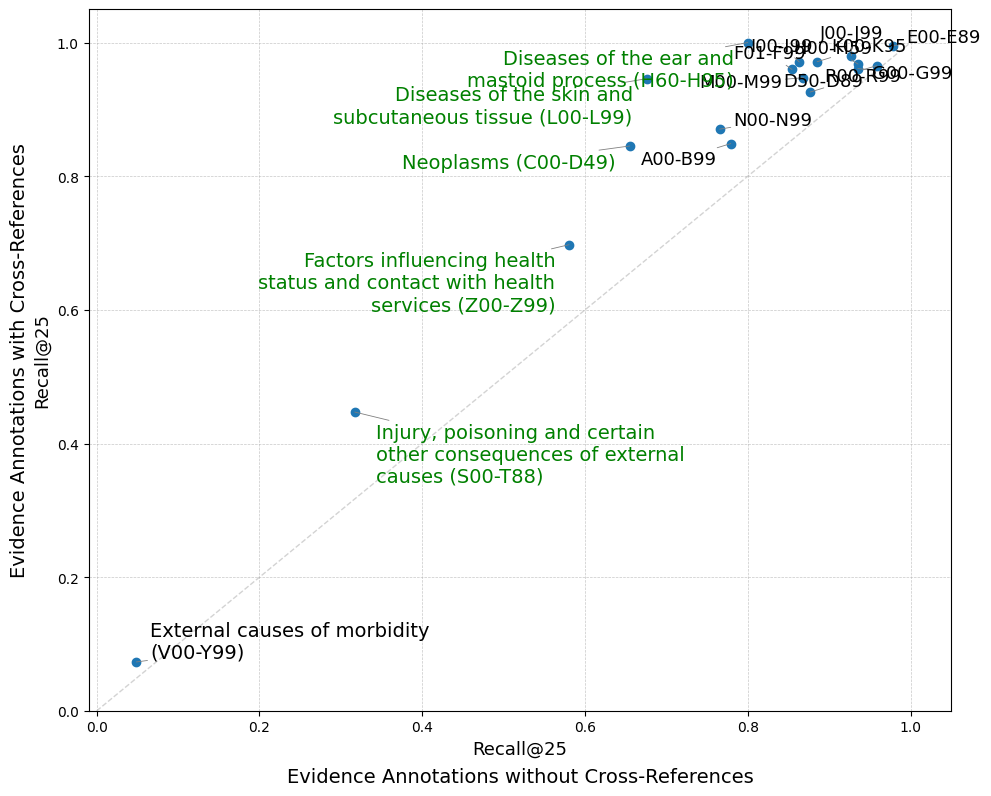

In [103]:
import matplotlib.pyplot as plt
import pandas as pd
import textwrap                       # NEW
from collections import Counter, defaultdict

all_target_codes = [code for row in mdace["targets"] for code in row]
codes_by_chapter = [xml_trie.get_chapter_id(code) for code in all_target_codes]
chapters = {
    xml_trie.get_chapter_id(code): xml_trie.get_chapter(code) for code in all_target_codes
}
chapter_freq = Counter(codes_by_chapter)

chapter_data = defaultdict(dict)
for chapter_id, freq in chapter_freq.items():
    chapter_data[chapter_id] = {
        "label": f"{chapters[chapter_id].min}-{chapters[chapter_id].max}",
    }

# --- per-chapter recall ---
base_chapters_tp = Counter()
base_chapters_total = Counter()

for idx, res in enumerate(grouped_retrieved_codes):
    row = mdace[idx]
    target_codes = row["targets"]

    for code in target_codes:
        ch_id = xml_trie.get_chapter_id(code)
        base_chapters_total[ch_id] += 1
        if code in res:
            base_chapters_tp[ch_id] += 1

extended_chapters_tp = Counter()
extended_chapters_total = Counter()

for idx, res in enumerate(group_extended_retrieved_codes):
    row = mdace[idx]
    target_codes = row["targets"]

    for code in target_codes:
        ch_id = xml_trie.get_chapter_id(code)
        extended_chapters_total[ch_id] += 1
        if code in res:
            extended_chapters_tp[ch_id] += 1

# --- dataframe for plotting ---
total_targets = len(all_target_codes)
rows = []
for ch_id, freq in chapter_freq.items():
    base_recall = base_chapters_tp[ch_id] / base_chapters_total[ch_id] if base_chapters_total[ch_id] else 0.0
    extended_recall = extended_chapters_tp[ch_id] / extended_chapters_total[ch_id] if extended_chapters_total[ch_id] else 0.0
    rows.append(
        {
            "chapter_id": ch_id,
            "frequency": freq,
            "extended_recall": extended_recall,
            "base_recall": base_recall,
            "label": chapter_data[ch_id]["label"],
        }
    )

df = pd.DataFrame(rows)
df = df[df["frequency"] >= 5]

# -----------------------------------------------------------------------------   
# Scatter plot with call-out labels
plt.figure(figsize=(10, 8))
plt.scatter(df["base_recall"], df["extended_recall"], zorder=2)
plt.xlabel("Recall@25", fontsize=13)
plt.ylabel("Recall@25", fontsize=13)
# Diagonal reference line (y = x) in light grey
plt.plot([0, 1], [0, 1], linestyle='--', color='lightgrey', linewidth=1, zorder=1)


plt.text(
    0.5, -0.08, "Evidence Annotations without Cross-References",
    transform=plt.gca().transAxes,
    ha="center", va="top", fontsize=14
)

# Add subtitle beside y-axis
plt.text(
    -0.08, 0.5, "Evidence Annotations with Cross-References",
    transform=plt.gca().transAxes,
    ha="center", va="center", rotation="vertical", fontsize=14
)

# Pre-compute medians to decide which way to push each label
x_med = df["base_recall"].median()
y_med = df["extended_recall"].median()

manual_offsets = {
    "L00-L99": {"dx": -10, "dy": -5, "ha": "right", "va": "top"},
    "I00-I99":   {"dx": 10, "dy": 5,    "ha": "right",  "va": "bottom"},
    "Z00-Z99": {"dx": -10, "dy": -5, "ha": "right", "va": "top"},
    "J00-J99": {"dx": 0, "dy": 10, "ha": "center", "va": "bottom"},
    "E00-E89": {"dx":  10, "dy": 0,  "ha": "left",  "va": "bottom"},
    "Q00-Q99":   {"dx": 12, "dy": 7, "ha": "left", "va": "bottom"},  # vertically above
    "C00-D49":   {"dx": -10, "dy": -5, "ha": "right", "va": "top"},
    "S00-T88":   {"dx": 15, "dy": -8, "ha": "left", "va": "top"},     # directly below
    "M00-M99":   {"dx": -15, "dy": -10,  "ha": "right", "va": "bottom"},
    "H60-H95": {"dx": -10, "dy": -5, "ha": "right", "va": "top"},
    "H00-H59": {"dx": 10, "dy": 5,    "ha": "right",  "va": "bottom"},
    "G00-G99": {"dx": 10, "dy": -10,  "ha": "left", "va": "bottom"},
    "F01-F99": {"dx": 10, "dy": 5,    "ha": "right",  "va": "bottom"},
    "A00-B99": {"dx": -10, "dy": -5, "ha": "right", "va": "top"},
    "D50-D89": {"dx": -10, "dy": -5, "ha": "right", "va": "top"},
    "N00-N99":   {"dx":  10, "dy": 0,  "ha": "left",  "va": "bottom"},
    "V00-Y99":   {"dx":  10, "dy": 0,  "ha": "left",  "va": "bottom"},
    "default":   {"dx": 10, "dy": 5,    "ha": "left",  "va": "bottom"},
}


red_highlight_labels = []
green_highlight_labels = ["H60-H99", "L00-L99", "Z00-Z99", "H60-H95", "C00-D49", "S00-T88"]
highlight_labels = red_highlight_labels + green_highlight_labels
for _, r in df.iterrows():
    x, y, label, ch_id = r["base_recall"], r["extended_recall"], r["label"], r["chapter_id"]
    color = "red" if label in red_highlight_labels else ("green" if label in green_highlight_labels else "black")
    font_size = 13
    # Pick a direction: push left or right, up or down away from the plot centre

    opts = manual_offsets.get(r["label"], manual_offsets["default"])
    dx, dy = opts["dx"], opts["dy"]
    ha, va = opts["ha"], opts["va"]

    if label in highlight_labels or label in["V00-Y99", "C00-D49", "S00-T88"]:
        label = chapters[ch_id].description
        font_size = 14
    wrapped = textwrap.fill(label, width=30)

    # Annotate with an arrow-less leader line (arrowstyle "-" draws a straight line)
    plt.annotate(
        wrapped,
        xy=(x, y),
        xytext=(dx, dy),
        textcoords="offset points",
        ha=ha,
        va=va,
        fontsize=font_size,
        color=color,
        arrowprops=dict(
            arrowstyle="-",
            shrinkA=0,
            shrinkB=0,
            lw=0.6,
            color="grey",
        ),
        zorder=3
    )
plt.ylim(0.0, 1.05)
plt.xlim(-0.01, 1.05)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [104]:
df.rename(columns={
    "base_recall": "base",
    "extended_recall": "with_cross_references"
}, inplace=True)

# Compute recall difference
df["recall_change"] = df["with_cross_references"] - df["base"]

# Compute overall weighted values
total_freq = df["frequency"].sum()
overall_base = (df["frequency"] * df["base"]).sum() / total_freq
overall_cross = (df["frequency"] * df["with_cross_references"]).sum() / total_freq
overall_change = overall_cross - overall_base

# Create summary row
summary_row = pd.DataFrame([{
    "chapter_id": "overall",
    "frequency": total_freq,
    "base": overall_base,
    "with_cross_references": overall_cross,
    "recall_change": overall_change,
    "label": "All Chapters"
}])


df_with_summary = pd.concat([df, summary_row], ignore_index=True)
df_with_summary = df_with_summary[["chapter_id", "frequency", "base", "with_cross_references", "recall_change", "label"]]

df_with_summary.sort_values(by="chapter_id")

,chapter_id,frequency,base,with_cross_references,recall_change,label
5,cm_1,86,0.779070,0.848837,0.069767,A00-B99
8,cm_10,206,0.927184,0.980583,0.053398,J00-J99
4,cm_11,244,0.885246,0.971311,0.086066,K00-K95
16,cm_12,37,0.675676,0.945946,0.270270,L00-L99
7,cm_13,114,0.868421,0.947368,0.078947,M00-M99
10,cm_14,162,0.765432,0.870370,0.104938,N00-N99
9,cm_18,162,0.876543,0.925926,0.049383,R00-R99
12,cm_19,123,0.317073,0.447154,0.130081,S00-T88
14,cm_2,84,0.654762,0.845238,0.190476,C00-D49
13,cm_20,41,0.048780,0.073171,0.024390,V00-Y99


In [15]:
df.rename(columns={
    "base_recall": "base",
    "extended_recall": "with_cross_references"
}, inplace=True)

# Compute recall difference
df["recall_change"] = df["with_cross_references"] - df["base"]

# Compute overall weighted values
total_freq = df["frequency"].sum()
overall_base = (df["frequency"] * df["base"]).sum() / total_freq
overall_cross = (df["frequency"] * df["with_cross_references"]).sum() / total_freq
overall_change = overall_cross - overall_base

# Create summary row
summary_row = pd.DataFrame([{
    "chapter_id": "overall",
    "frequency": total_freq,
    "base": overall_base,
    "with_cross_references": overall_cross,
    "recall_change": overall_change,
    "label": "All Chapters"
}])


df_with_summary = pd.concat([df, summary_row], ignore_index=True)
df_with_summary = df_with_summary[["chapter_id", "frequency", "base", "with_cross_references", "recall_change", "label"]]

df_with_summary.sort_values(by="chapter_id")

,chapter_id,frequency,base,with_cross_references,recall_change,label
5,cm_1,86,0.767442,0.848837,0.081395,A00-B99
8,cm_10,206,0.922330,0.932039,0.009709,J00-J99
4,cm_11,244,0.872951,0.942623,0.069672,K00-K95
16,cm_12,37,0.756757,0.891892,0.135135,L00-L99
7,cm_13,114,0.850877,0.877193,0.026316,M00-M99
10,cm_14,162,0.870370,0.895062,0.024691,N00-N99
9,cm_18,162,0.851852,0.864198,0.012346,R00-R99
12,cm_19,123,0.308943,0.406504,0.097561,S00-T88
14,cm_2,84,0.595238,0.702381,0.107143,C00-D49
13,cm_20,41,0.024390,0.024390,0.000000,V00-Y99


In [44]:
embed_config: list[dict[str, str]] = [
        {
            "type": "st",
            "model_name": "pritamdeka/S-PubMedBert-MS-MARCO",
            "query_key": "evidence",
        }
    ]

# Perform search
extended_evidence_results = qdrant_factory.search(
    data=queries,
    model_cfg=embed_config,
    service=qdrant_service,
    index_name=index_finger_print,
    limit=25,
)

extended_retrieved_codes = []
for idx, res in enumerate(extended_evidence_results):
    accumulated_codes = set()
    for point in res.points:
        if not point.payload:
            continue
        term = xml_trie.index[point.payload["id"]]
        accumulated_codes.update(
            xml_trie.get_term_codes(term.id, subterms=False)
        )
    extended_retrieved_codes.append(list(accumulated_codes))

Output()

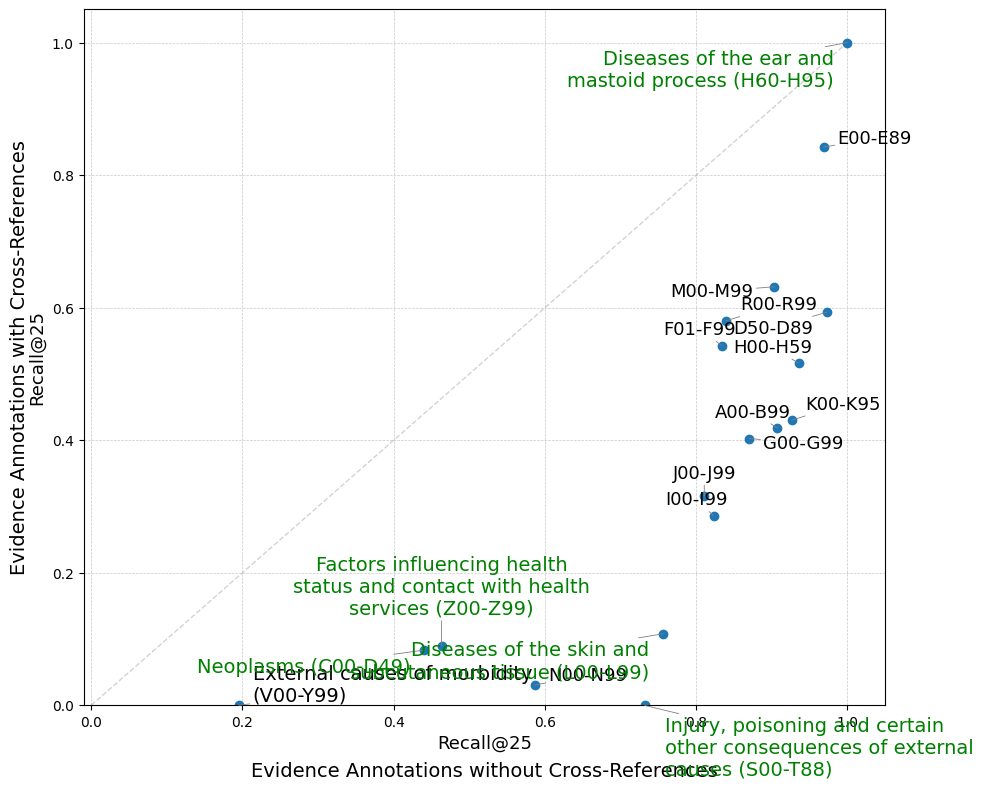

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
import textwrap                       # NEW
from collections import Counter, defaultdict

all_target_codes = [code for row in mdace["targets"] for code in row]
codes_by_chapter = [xml_trie.get_chapter_id(code) for code in all_target_codes]
chapters = {
    xml_trie.get_chapter_id(code): xml_trie.get_chapter(code) for code in all_target_codes
}
chapter_freq = Counter(codes_by_chapter)

chapter_data = defaultdict(dict)
for chapter_id, freq in chapter_freq.items():
    chapter_data[chapter_id] = {
        "label": f"{chapters[chapter_id].min}-{chapters[chapter_id].max}",
    }

# --- per-chapter recall ---
base_chapters_tp = Counter()
base_chapters_total = Counter()

for idx, res in enumerate(base_retrieved_codes):
    row = mdace[idx]
    target_codes = row["targets"]

    for code in target_codes:
        ch_id = xml_trie.get_chapter_id(code)
        base_chapters_total[ch_id] += 1
        if code in res:
            base_chapters_tp[ch_id] += 1

extended_chapters_tp = Counter()
extended_chapters_total = Counter()

for idx, res in enumerate(extended_retrieved_codes):
    row = mdace[idx]
    target_codes = row["targets"]

    for code in target_codes:
        ch_id = xml_trie.get_chapter_id(code)
        extended_chapters_total[ch_id] += 1
        if code in res:
            extended_chapters_tp[ch_id] += 1

# --- dataframe for plotting ---
total_targets = len(all_target_codes)
rows = []
for ch_id, freq in chapter_freq.items():
    base_recall = base_chapters_tp[ch_id] / base_chapters_total[ch_id] if base_chapters_total[ch_id] else 0.0
    extended_recall = extended_chapters_tp[ch_id] / extended_chapters_total[ch_id] if extended_chapters_total[ch_id] else 0.0
    rows.append(
        {
            "chapter_id": ch_id,
            "frequency": freq,
            "extended_recall": extended_recall,
            "base_recall": base_recall,
            "label": chapter_data[ch_id]["label"],
        }
    )

df = pd.DataFrame(rows)
df = df[df["frequency"] >= 5]

# -----------------------------------------------------------------------------   
# Scatter plot with call-out labels
plt.figure(figsize=(10, 8))
plt.scatter(df["base_recall"], df["extended_recall"], zorder=2)
plt.xlabel("Recall@25", fontsize=13)
plt.ylabel("Recall@25", fontsize=13)
# Diagonal reference line (y = x) in light grey
plt.plot([0, 1], [0, 1], linestyle='--', color='lightgrey', linewidth=1, zorder=1)


plt.text(
    0.5, -0.08, "Evidence Annotations without Cross-References",
    transform=plt.gca().transAxes,
    ha="center", va="top", fontsize=14
)

# Add subtitle beside y-axis
plt.text(
    -0.08, 0.5, "Evidence Annotations with Cross-References",
    transform=plt.gca().transAxes,
    ha="center", va="center", rotation="vertical", fontsize=14
)

# Pre-compute medians to decide which way to push each label
x_med = df["base_recall"].median()
y_med = df["extended_recall"].median()

manual_offsets = {
    "L00-L99": {"dx": -10, "dy": -5, "ha": "right", "va": "top"},
    "I00-I99":   {"dx": 10, "dy": 5,    "ha": "right",  "va": "bottom"},
    "Z00-Z99": {"dx": 0, "dy": 20, "ha": "center", "va": "bottom"},
    "J00-J99": {"dx": 0, "dy": 10, "ha": "center", "va": "bottom"},
    "E00-E89": {"dx":  10, "dy": 0,  "ha": "left",  "va": "bottom"},
    "Q00-Q99":   {"dx": 12, "dy": 7, "ha": "left", "va": "bottom"},  # vertically above
    "C00-D49":   {"dx": -10, "dy": -5, "ha": "right", "va": "top"},
    "S00-T88":   {"dx": 15, "dy": -8, "ha": "left", "va": "top"},     # directly below
    "M00-M99":   {"dx": -15, "dy": -10,  "ha": "right", "va": "bottom"},
    "H60-H95": {"dx": -10, "dy": -5, "ha": "right", "va": "top"},
    "H00-H59": {"dx": 10, "dy": 5,    "ha": "right",  "va": "bottom"},
    "G00-G99": {"dx": 10, "dy": -10,  "ha": "left", "va": "bottom"},
    "F01-F99": {"dx": 10, "dy": 5,    "ha": "right",  "va": "bottom"},
    "A00-B99": {"dx": 10, "dy": 5,    "ha": "right",  "va": "bottom"},
    "D50-D89": {"dx": -10, "dy": -5, "ha": "right", "va": "top"},
    "N00-N99":   {"dx":  10, "dy": 0,  "ha": "left",  "va": "bottom"},
    "V00-Y99":   {"dx":  10, "dy": 0,  "ha": "left",  "va": "bottom"},
    "default":   {"dx": 10, "dy": 5,    "ha": "left",  "va": "bottom"},
}


red_highlight_labels = []
green_highlight_labels = ["H60-H99", "L00-L99", "Z00-Z99", "H60-H95", "C00-D49", "S00-T88"]
highlight_labels = red_highlight_labels + green_highlight_labels
for _, r in df.iterrows():
    x, y, label, ch_id = r["base_recall"], r["extended_recall"], r["label"], r["chapter_id"]
    color = "red" if label in red_highlight_labels else ("green" if label in green_highlight_labels else "black")
    font_size = 13
    # Pick a direction: push left or right, up or down away from the plot centre

    opts = manual_offsets.get(r["label"], manual_offsets["default"])
    dx, dy = opts["dx"], opts["dy"]
    ha, va = opts["ha"], opts["va"]

    if label in highlight_labels or label in["V00-Y99", "C00-D49", "S00-T88"]:
        label = chapters[ch_id].description
        font_size = 14
    wrapped = textwrap.fill(label, width=30)

    # Annotate with an arrow-less leader line (arrowstyle "-" draws a straight line)
    plt.annotate(
        wrapped,
        xy=(x, y),
        xytext=(dx, dy),
        textcoords="offset points",
        ha=ha,
        va=va,
        fontsize=font_size,
        color=color,
        arrowprops=dict(
            arrowstyle="-",
            shrinkA=0,
            shrinkB=0,
            lw=0.6,
            color="grey",
        ),
        zorder=3
    )
plt.ylim(0.0, 1.05)
plt.xlim(-0.01, 1.05)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [46]:
df.rename(columns={
    "base_recall": "base",
    "extended_recall": "with_cross_references"
}, inplace=True)

# Compute recall difference
df["recall_change"] = df["with_cross_references"] - df["base"]

# Compute overall weighted values
total_freq = df["frequency"].sum()
overall_base = (df["frequency"] * df["base"]).sum() / total_freq
overall_cross = (df["frequency"] * df["with_cross_references"]).sum() / total_freq
overall_change = overall_cross - overall_base

# Create summary row
summary_row = pd.DataFrame([{
    "chapter_id": "overall",
    "frequency": total_freq,
    "base": overall_base,
    "with_cross_references": overall_cross,
    "recall_change": overall_change,
    "label": "All Chapters"
}])


df_with_summary = pd.concat([df, summary_row], ignore_index=True)
df_with_summary = df_with_summary[["chapter_id", "frequency", "base", "with_cross_references", "recall_change", "label"]]

df_with_summary.sort_values(by="chapter_id")

,chapter_id,frequency,base,with_cross_references,recall_change,label
5,cm_1,86,0.906977,0.418605,-0.488372,A00-B99
8,cm_10,206,0.810680,0.315534,-0.495146,J00-J99
4,cm_11,244,0.926230,0.430328,-0.495902,K00-K95
16,cm_12,37,0.756757,0.108108,-0.648649,L00-L99
7,cm_13,114,0.903509,0.631579,-0.271930,M00-M99
10,cm_14,162,0.586420,0.030864,-0.555556,N00-N99
9,cm_18,162,0.839506,0.580247,-0.259259,R00-R99
12,cm_19,123,0.731707,0.000000,-0.731707,S00-T88
14,cm_2,84,0.440476,0.083333,-0.357143,C00-D49
13,cm_20,41,0.195122,0.000000,-0.195122,V00-Y99
